In [1]:
using Gillespie
using Plots
using LinearAlgebra
using Random
using DelimitedFiles

In [2]:
# Model parameters.
ωA = 1.
ωB = 1.
ΩA = 0.
ΩB = 1.
γ = 0.1
g = 0.1

# Initial state.
ψ0_A = complex(float([1 ; 0]))
ψ0_B = complex(float([1 ; 0]))
ψ0 = kron(ψ0_A, ψ0_B)

# Simulation parameters.
t_final = 50.
dt = 0.01
number_trajectories = 400

# Operators.
σx = complex(float([0 1 ; 1 0]))
σy = complex(float([0 -1im ; 1im 0]))
σz = complex(float([1 0 ; 0 -1]))
ide = complex(float([1 0 ; 0 1]))
σp = (σx + 1im * σy)/2
σ = σp'
# Tensorized versions.
σ_A = kron(σ, ide)
σ_B = kron(ide, σ)
σx_A = kron(σx, ide)
σx_B = kron(ide, σx)
σz_A = kron(σz, ide)
σz_B = kron(ide, σz)

# Hamiltonian.
H = ωA * σz_A + ωB * σz_B + ΩA * σx_A + ΩB * σx_B + g * (σ_A * σ_B' + σ_A' * σ_B)

# Jump operator.
M = sqrt(γ) * σ_B

# The jump operators have to be passed as lists.
M_l = [M];

# Number operator.
num_op = [0 0 ; 0 1]
num_op_B = kron(ide, num_op)

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  1.0+0.0im

In [3]:
Random.seed!(2)
results_1 = Gillespie.compute_states_at_times(H, M_l, ψ0, t_final, dt, number_trajectories, false);
Random.seed!(4)
results_2 = Gillespie.compute_states_at_times(H, M_l, ψ0, t_final, dt, number_trajectories, false);

Filling in the gaps... 100%|█████████████████████████████| Time: 0:00:01
Filling in the gaps... 100%|█████████████████████████████| Time: 0:00:01


-> Truncation error given by norm of latest Qs matrix: 0.011999073627007282

-> Truncation error given by norm of latest Qs matrix: 0.011999073627007282



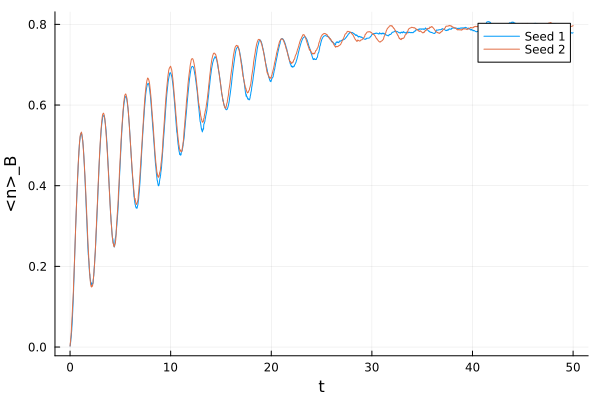

"/Users/marco.radaelli/Desktop/GillespieQuantumJumps/QutipBenchmark/gillespie_internal_error.png"

In [4]:
σp_B = kron(ide, [0 0 ; 0 1])

v_ave_up_B_1 = zeros(length(0:dt:t_final))
for n_traj in 1:number_trajectories
    for n_t in eachindex(results_1[1])
        ψ = results_1[n_traj][n_t]
        ρ = ψ * ψ'
        v_ave_up_B_1[n_t] += (tr(ρ * σp_B)).re / number_trajectories
    end
end

v_ave_up_B_2 = zeros(length(0:dt:t_final))
for n_traj in 1:number_trajectories
    for n_t in eachindex(results_2[1])
        ψ = results_2[n_traj][n_t]
        ρ = ψ * ψ'
        v_ave_up_B_2[n_t] += (tr(ρ * σp_B)).re / number_trajectories
    end
end

plot(0:dt:t_final, v_ave_up_B_1, xlabel="t", ylabel="<n>_B", label="Seed 1")
display(plot!(0:dt:t_final, v_ave_up_B_2, xlabel="t", ylabel="<n>_B", label="Seed 2"))
savefig("gillespie_internal_error.png")

In [5]:
error = norm(v_ave_up_B_1 - v_ave_up_B_2)

0.8580067801529534

In [6]:
# Comparison of error with the Qutip version.
fname = "results_qutip.txt"
qutip_results = vec(readdlm(fname,Float64))
gillespie_results = v_ave_up_B_2[2:end]

5000-element Vector{Float64}:
 0.0050992907346529585
 0.010395028825492949
 0.010888017758097314
 0.01157715482186119
 0.012462183714661481
 0.018524678298173093
 0.022280832432914604
 0.02373741148662948
 0.02786404289587756
 0.02969516881307801
 0.034183178095012014
 0.036381112054179064
 0.04122021914745044
 ⋮
 0.7952939870992863
 0.7952894834350132
 0.7952810688769749
 0.7957765403307955
 0.7957691069780978
 0.7964862908893517
 0.7964792261625325
 0.7964673035380472
 0.7964505904064326
 0.7964291578496988
 0.7964030805656253
 0.7968955202767923

In [7]:
discrepancy_vector = qutip_results - gillespie_results
# Absolute value.
abs_discrepancy_vector = [abs(x) for x in discrepancy_vector]
norm(abs_discrepancy_vector)

1.5258929976244053

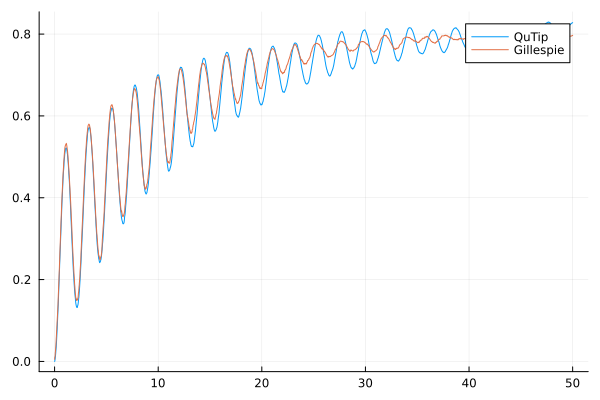

In [8]:
plot(dt:dt:t_final, qutip_results, label="QuTip")
plot!(dt:dt:t_final, gillespie_results, label="Gillespie")

In [9]:
savefig("discrepancy_qutip_gillespie.png")

"/Users/marco.radaelli/Desktop/GillespieQuantumJumps/QutipBenchmark/discrepancy_qutip_gillespie.png"

In [10]:
# Now include also the exact version.
fname = "results_qutip.txt"
qutip_results = vec(readdlm(fname,Float64))
gillespie_results = v_ave_up_B_2[2:end]
fname = "results_exact.txt"
exact_results = vec(readdlm(fname,Float64));

In [11]:
length(0:dt:t_final)

5001

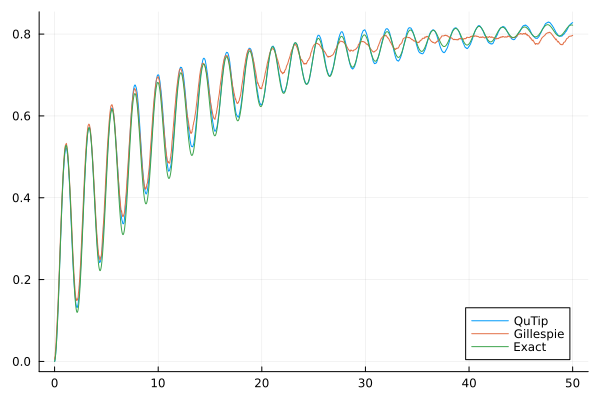

In [12]:
plot(dt:dt:t_final, qutip_results, label="QuTip", legend=:bottomright)
plot!(dt:dt:t_final, gillespie_results, label="Gillespie")
display(plot!(dt:dt:t_final, exact_results, label="Exact"))

In [13]:
savefig("comparison_with_exact.png")

"/Users/marco.radaelli/Desktop/GillespieQuantumJumps/QutipBenchmark/comparison_with_exact.png"

In [21]:
results_V = Gillespie.compute_states_at_times(H, M_l, ψ0, t_final, dt, number_trajectories, false,false);
results_no_V = Gillespie.compute_states_at_times(H, M_l, ψ0, t_final, dt, number_trajectories, false,true);

Filling in the gaps... 100%|█████████████████████████████| Time: 0:00:01
Filling in the gaps... 100%|█████████████████████████████| Time: 0:00:12


-> Truncation error given by norm of latest Qs matrix: 0.011999073627007282

-> Truncation error given by norm of latest Qs matrix: 0.011999073627007282



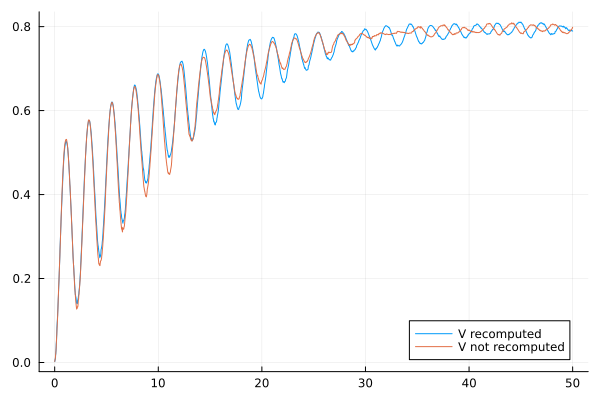

In [29]:
v_ave_up_no_V = zeros(length(0:dt:t_final))
for n_traj in 1:number_trajectories
    for n_t in eachindex(results_1[1])
        ψ = results_no_V[n_traj][n_t]
        ρ = ψ * ψ'
        v_ave_up_no_V[n_t] += (tr(ρ * σp_B)).re / number_trajectories
    end
end

v_ave_up_V = zeros(length(0:dt:t_final))
for n_traj in 1:number_trajectories
    for n_t in eachindex(results_1[1])
        ψ = results_V[n_traj][n_t]
        ρ = ψ * ψ'
        v_ave_up_V[n_t] += (tr(ρ * σp_B)).re / number_trajectories
    end
end

plot(0:dt:t_final, v_ave_up_no_V, label="V recomputed", legend=:bottomright)
display(plot!(0:dt:t_final, v_ave_up_V, label="V not recomputed"))

In [30]:
savefig("Vrecomputed_vs_non_recomputed.png")

"/Users/marco.radaelli/Desktop/GillespieQuantumJumps/QutipBenchmark/Vrecomputed_vs_non_recomputed.png"

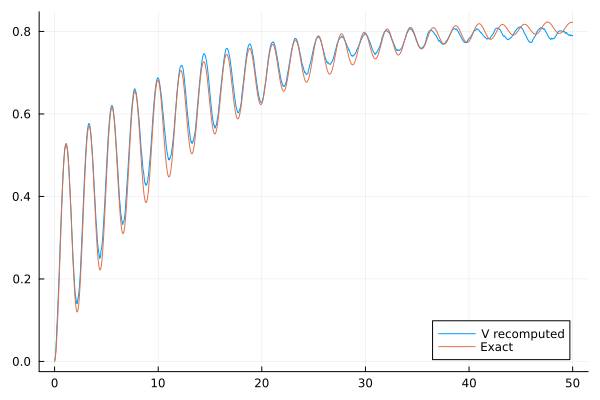

In [31]:
# Comparison with the exact value.
plot(dt:dt:t_final, v_ave_up_no_V[2:end], label="V recomputed", legend=:bottomright)
display(plot!(dt:dt:t_final, exact_results, label="Exact"))

In [32]:
savefig("V_recomputed_vs_exact")

"/Users/marco.radaelli/Desktop/GillespieQuantumJumps/QutipBenchmark/V_recomputed_vs_exact.png"